In [ ]:
# importing required libraries
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates 
from sklearn.metrics import mean_squared_error
import math
pd.options.mode.chained_assignment = None 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [ ]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# importing the test and training dataset from drive
train_link = 'https://drive.google.com/open?id=1YCmgG6EoeW-suoO9pEJKUzIMBv3iAlew'
test_link = 'https://drive.google.com/open?id=17H0OUGoC3-Ld-qITR8QWDIICipS8I9al'

In [ ]:
# extracting the file ids from the url
fluff, train_id = train_link.split('=')
fluff, test_id = test_link.split('=')

In [ ]:
# validating whether the entire extraction was perfect
print(train_id)
print(test_id)

1YCmgG6EoeW-suoO9pEJKUzIMBv3iAlew
17H0OUGoC3-Ld-qITR8QWDIICipS8I9al


In [ ]:
#loading the training dataset
downloaded_train = drive.CreateFile({'id':train_id}) 
downloaded_train.GetContentFile('Training.csv')  
training_df = pd.read_csv('Training.csv')

#loading the test dataset
downloaded_test = drive.CreateFile({'id':test_id}) 
downloaded_test.GetContentFile('Test.csv')
test_df = pd.read_csv('Test.csv')

In [ ]:
# quickly looking into the training dataset 
training_df.head()

,vendor_name,enterprise_name,total_amount,repayment_date
0,A,DO,38314,2019-03-11
1,A,DO,406447,2019-03-19
2,A,DO,47904,2019-03-20
3,A,DO,37547,2019-03-26
4,A,DO,186274,2019-04-04


In [ ]:
# quickly looking into the test dataset 
test_df.head()

,vendor_name,enterprise_name,total_amount,repayment_date
0,A,DO,24520,2020-02-17
1,A,DO,8820,2020-02-20
2,A,DO,129760,2020-02-25
3,A,DO,185185,2020-02-26
4,A,DO,136382,2020-02-27


In [ ]:
# Getting the count of transactions per vendor-enterprise pair
df2 = training_df.groupby(['vendor_name', 'enterprise_name']).count()

In [ ]:
# printing the same
df2

total_amount  repayment_date
vendor_name enterprise_name                              
A           DO                         99              99
            LP                         11              11
AA          FQ                         26              26
            IF                         14              14
            IG                         55              55
...                                   ...             ...
YR          KS                         11              11
            KV                         30              30
            UD                         10              10
            YR                         14              14
Z           FP                         83              83

[243 rows x 2 columns]

In [ ]:
# Extracting the data for first enterprise vendor pair to analyse it.
sampled_df_1 = training_df.loc[(training_df['vendor_name'] == 'A') & (training_df['enterprise_name'] == 'DO')]

In [ ]:
#printing the same
sampled_df_1

,vendor_name,enterprise_name,total_amount,repayment_date
0,A,DO,38314,2019-03-11
1,A,DO,406447,2019-03-19
2,A,DO,47904,2019-03-20
3,A,DO,37547,2019-03-26
4,A,DO,186274,2019-04-04
...,...,...,...,...
94,A,DO,23840,2020-02-11
95,A,DO,24718,2020-02-13
96,A,DO,123196,2020-03-11
97,A,DO,88260,2020-03-20


In [ ]:
#printing the datatypes of all the columns in pandas dataframe
print(sampled_df_1.dtypes)

vendor_name        object
enterprise_name    object
total_amount        int64
repayment_date     object
dtype: object


In [ ]:
# Converting the datatype of repayment_date to datetime 
sampled_df_1.loc[:, 'repayment_date'] = pd.to_datetime(sampled_df_1['repayment_date'].str.strip(), format='%Y-%m-%d')
print ('\n Parsed Data:')
print (sampled_df_1.head())


 Parsed Data:
  vendor_name enterprise_name  total_amount repayment_date
0           A              DO         38314     2019-03-11
1           A              DO        406447     2019-03-19
2           A              DO         47904     2019-03-20
3           A              DO         37547     2019-03-26
4           A              DO        186274     2019-04-04


In [ ]:
# Printing the datatypes to verify whether datatype for repayment date is changed or not
print(sampled_df_1.dtypes)

vendor_name                object
enterprise_name            object
total_amount                int64
repayment_date     datetime64[ns]
dtype: object


In [ ]:
# droppping the vendor_name and enterprise column as they are no longer needed
sampled_df_1.drop(['vendor_name', 'enterprise_name'], axis = 1, inplace = True) 

In [ ]:
# setting repayment_date as index and converting the data to daywise
sampled_df_1.set_index('repayment_date', inplace=True)
sampled_df_daily = sampled_df_1.resample('D').sum().fillna(0)

In [ ]:
# Normalize our data to fall between 0 and ones since LSTM is a neural network 
scaler = MinMaxScaler(feature_range = (0, 1))
training_scaled = scaler.fit_transform(sampled_df_daily)

In [ ]:
# Visulaizing the data
training_scaled

array([[0.09426567],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [1.        ],
       [0.11786039],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.09237859],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.45829838],
       [0.1060089 ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.0541399 ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.29637567],
       [0.        ],
       [0.6190229 ],
       [0.0713943 ],
       [0.        ],
       [0.   

In [ ]:
#Converting the data into features and labels i. e. using first 60 data values to predict the 61st value and label is the target value i. e. dependent variable 
features_set = []
labels = []
for i in range(60, 100):
    features_set.append(training_scaled[i-60:i, 0])
    labels.append(training_scaled[i, 0])

In [ ]:
# Converting the data into numpy array to use it for training
features_set, labels = np.array(features_set), np.array(labels)

In [ ]:
#Converting the input data into proper format that can be used by lstm
#First dimension = number of rows =99
#Second dimension = number of steps = 60
#Third dimension = number of features or indicators i.e. 1 in our case
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))

In [ ]:
#Instantiating the sequential class
model = Sequential()

In [ ]:
# Adding one lstm layer with 50 neurons, returning a sequence since we will add more layers to it,
# input_shape(number of steps, number of indicators)
model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1)))

In [ ]:
# Adding a dropout layer to avoid overfitting with dropout = 0.2 i. e. set 20% of the neurons to 0
model.add(Dropout(0.2))

In [ ]:
# Adding three more lstm and dropout layers to our sequence model
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

In [ ]:
# Adding a dense layer at the end to make our model more robust with one unit since we want to output a single value or feature
model.add(Dense(units = 1))

In [ ]:
# Compliting our model(Sequence model) before training, using mean square as the loss function and using adam optimizer to optimize the algorithm
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
# Training our model with the feature set and telling the target labels
model.fit(features_set, labels, epochs = 100, batch_size = 32)

Epoch 1/100
40/40 [==============================] - 1s 37ms/step - loss: 0.0062
Epoch 2/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0055
Epoch 3/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0054
Epoch 4/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0054
Epoch 5/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0053
Epoch 6/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0052
Epoch 7/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0053
Epoch 8/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0054
Epoch 9/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0055
Epoch 10/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0055
Epoch 11/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0056
Epoch 12/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0054
Epoch 13/100
40/40 [================

In [ ]:
# Sampling the test data to get data of only vendor 'A' and enterprise 'DO' 
testing_complete = test_df.groupby(['vendor_name', 'enterprise_name']).count()
testing_processed = test_df.loc[(test_df['vendor_name'] == 'A') & (test_df['enterprise_name'] == 'DO')]

In [ ]:
# COnverting the repayment date to proper format
testing_processed.loc[:, 'repayment_date'] = pd.to_datetime(testing_processed['repayment_date'].str.strip(), format='%Y-%m-%d')

In [ ]:
# droppping the vendor_name and enterprise column as they are no longer needed
testing_processed.drop(['vendor_name', 'enterprise_name'], axis = 1, inplace = True) 

In [ ]:
# setting repayment_date as index and converting the data to daywise data
testing_processed.set_index('repayment_date', inplace=True)
testing_processed = testing_processed.resample('D').sum().fillna(0)

In [ ]:
# for the purpose of forcasting, we need previous 60 days data thus concatenating the training and test data
total = pd.concat((sampled_df_daily, testing_processed), axis=0)

In [ ]:
# Now for predicting, the transaction for next 17 days, we need data 60 days data from the training set and 17 days data from the test set so total 77 days of data
# Thus extracting that data i. e. 77 rows
test_inputs = total[len(total) - len(testing_processed) - 60:].values

In [ ]:
# Checking the dimensions of the same
test_inputs.shape

(77, 1)

In [ ]:
# Scaling our test data to be fed to our model
test_inputs = test_inputs.reshape(-1,1)

# Transforming the data values to lie between 0 and 1
test_inputs = scaler.transform(test_inputs)

In [ ]:
# Preparing our test input data i. e. data of 60 days for predicting 61st day, next 60 days for predicting 62nd day and so on
test_features = []
for i in range(60,77):
    test_features.append(test_inputs[i-60:i, 0])

In [ ]:
test_features

[array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.28322512, 0.        , 0.12425236, 0.        , 0.        ,
        0.        , 0.        , 0.04120586, 0.        , 0.06847879,
        0.        , 0.        , 0.08109544, 0.05865463, 0.        ,
        0.06081482, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.30310471, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.21715008, 0.        , 0.        , 0.06967944]),
 array([0.        , 0.        , 0.        , 0.        , 0.28322512,
        0.        , 0.12425236, 0.        , 0.        , 0.        ,
        0.        , 0.04120586, 0.        , 0.

In [ ]:
# Converting our data to 3 d format to be fed to our neural network
test_features = np.array(test_features)
#np.reshape(data, (number of rows, number of intervals, number of features))
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

In [ ]:
# Making the predictions
predictions = model.predict(test_features)

In [ ]:
# Predictions made are scaled so we need to transform them back to the original scale by applying inverse transfrom of the scaler object on our predictions
predictions = scaler.inverse_transform(predictions)

In [ ]:
#Adding the repayment date column as an index to the predictions for evaluating the performance of the model
predictions_df= pd.DataFrame(testing_processed.index) 
predictions_df.set_index('repayment_date', inplace=True)
predictions_list = []
for i in range(17):
  predictions_list.append(predictions[i][0])
predictions_list
predictions_series = pd.Series(predictions_list)
predictions_df['total_amount'] = predictions_series.values

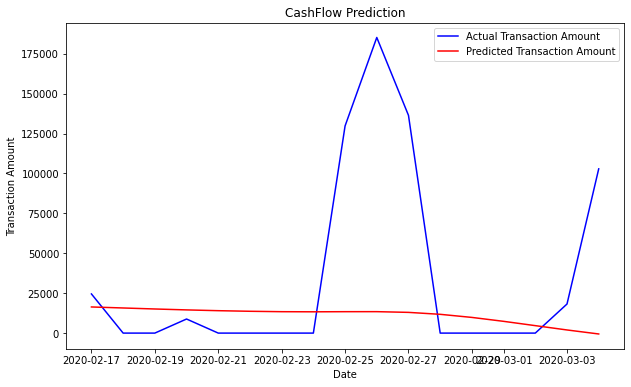

In [ ]:
# Plotting the output
plt.figure(figsize=(10,6))
plt.plot(testing_processed, color='blue', label='Actual Transaction Amount')
plt.plot(predictions_df , color='red', label='Predicted Transaction Amount')
plt.title('CashFlow Prediction')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')
plt.legend()
plt.show()

In [ ]:
# Calculating the rmse
mse = mean_squared_error(testing_processed, predictions_df)
rmse = math.sqrt(mse)
print(rmse)

64558.08989679426
